In [19]:
import os, jax
import numpy as np
import pandas as pd
import thesis.jaxdaw as jd
jdist = jd.distributions

import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random, vmap
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy
from thesis.io import fgong, gyre
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
# root_path = os.path.expanduser("/var/local/Scratch/ajl573/data/solar_models/y0.28/")

profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [20]:
from glob import glob
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [3]:
nu_max_sol = 3090.0
g_sol = 10**4.4374
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5
print(f"{nu_max=:.2f}")

nu_max=3035.44


In [4]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [14]:
name = "best"

obs = pd.read_csv(f"data/glitch-inputs-{name}.csv")
v19 = pd.read_csv(f"data/v19-glitch-results-{name}.csv", index_col=0)
gp = jd.load_results(f"data/gp-glitch-results-{name}.h5")

In [26]:
n = np.arange(obs.n.min()-5, obs.n.max()+1)
nu_true = pulse.freq.real.sel(l=0, n_pg=n)

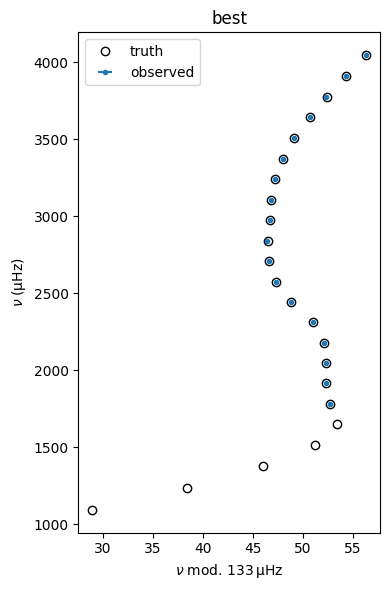

In [30]:
fig, ax = plt.subplots(figsize=(4, 6))
delta_nu = 133.0

ax.errorbar(obs.nu%delta_nu, obs.nu, xerr=obs.nu_err, fmt=".", label="observed")

# ax.plot(obs.nu_true%delta_nu, obs.nu_true, "ok", markerfacecolor="none", label="truth")
ax.plot(nu_true%delta_nu, nu_true, "ok", markerfacecolor="none", label="truth")
ax.set_title(k)
ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")

ax.legend()
ax.set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
# fig.supxlabel(f"$\\nu\\,\\% \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
# fig.supylabel(r"$\nu\;(\mathrm{\mu Hz})$")
fig.tight_layout()

In [31]:
rng = random.PRNGKey(2023)

In [32]:
shape = (1000,)
rng, key = random.split(rng)
gps = jd.resample(key, gp, shape=shape)

In [33]:
model = {}
n, nu, nu_err = obs.n.to_numpy(), obs.nu.to_numpy(), obs.nu_err.to_numpy()
delta_nu = jdist.Normal(132.8, 0.1)
epsilon = jdist.Normal(1.4, 0.05)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

In [34]:
def _oscillation(nu, tau, phi):
    return np.sin(4 * np.pi * tau * nu + phi)

def poly(p, x):
    powers = np.arange(p.shape[-1])
    return np.sum(p*x[..., None]**powers, axis=-1)

def smooth_component(param, n, npoly_params=5):
    return np.apply_along_axis(
        poly, 
        -1,
        param[..., :npoly_params], 
        n,
    )

def helium_amp(param, nu):
    return param[..., -4, None] * nu * np.exp(- 8e-12 * np.pi**2 * param[..., -3, None]**2 * nu**2)

def helium_glitch(param, nu):
    return helium_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -2, None], param[..., -1, None])

def bcz_amp(param, nu):
    return param[..., -7, None] / nu**2

def bcz_glitch(param, nu):
    return bcz_amp(param, nu) * _oscillation(nu, 1e-6*param[..., -6, None], param[..., -5, None])

def glitch(param, nu):
    return helium_glitch(param, nu) + bcz_glitch(param, nu)

Text(0.5, 0, '$\\nu\\;\\mathrm{mod}. \\,133\\,\\mathrm{\\mu Hz}$')

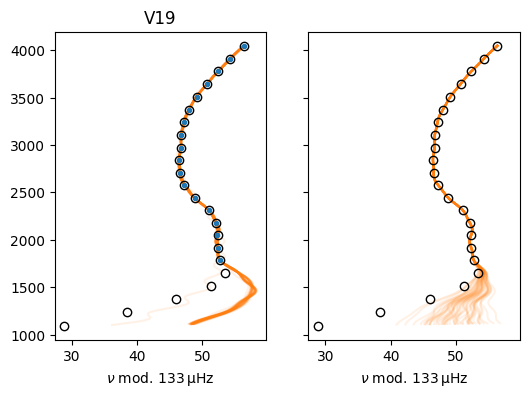

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True, sharex=True, 
                         )
draws = 50
delta_nu = 133.0

ax = axes[0]
ax.set_title("V19")
lobs = ax.errorbar(obs.nu%delta_nu, obs.nu, xerr=obs.nu_err, fmt=".", label="observed")

thin = len(v19) // draws
n_pred = np.linspace(n.min()-5, n.max(), 201)
param = v19.iloc[:, :-2].to_numpy()

nu_pred = smooth_component(param, n_pred)
nu_pred += glitch(param, nu_pred)
x = (nu_pred - n_pred * delta_nu) % delta_nu
ldraw = ax.plot(x[::thin].T, nu_pred[::thin].T, color="C1", alpha=0.1)

ltrue, = ax.plot(nu_true%delta_nu, nu_true, "ok",
        markerfacecolor="none", label="truth")
ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")


ax = axes[1]
thin = len(gps["delta_nu"]) // draws
keys = random.split(rng, draws)
gps_thinned = jax.tree_map(lambda x: x[::thin], gps)
nu_pred = jax.vmap(model.sample, in_axes=(0, 0, None))(keys, gps_thinned, n_pred)
x = (nu_pred - n_pred * delta_nu) % delta_nu
ldraw = ax.plot(x.T, nu_pred.T, color="C1", alpha=0.1)

ax.plot(nu_true%delta_nu, nu_true, "ok", markerfacecolor="none", label="truth")
ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")


In [53]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.6), sharey=True, sharex=True)
draws = 50
delta_nu = 133.0

ax = axes[0]
ax.set_title("V19 method")
lobs = ax.errorbar(obs.nu%delta_nu, obs.nu, xerr=obs.nu_err, fmt=".", label="observed")

thin = len(v19) // draws
n_pred = np.linspace(n.min()-5, n.max(), 201)
param = v19.iloc[:, :-2].to_numpy()

nu_pred = smooth_component(param, n_pred)
x = (nu_pred - n_pred * delta_nu) % delta_nu
ldraw = ax.plot(x[::thin].T, nu_pred[::thin].T, color="C1", alpha=0.1)

ltrue, = ax.plot(nu_true%delta_nu, nu_true, "ok", markerfacecolor="none", label="truth")
ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")
ax.set_ylabel(r"$\nu\;(\mathrm{\mu Hz})$")
ax.legend();

ax = axes[1]
ax.set_title("GP method")
lobs = ax.errorbar(obs.nu%delta_nu, obs.nu, xerr=obs.nu_err, fmt=".", label="observed")

thin = len(gps["delta_nu"]) // draws
keys = random.split(rng, draws)
gps_thinned = jax.tree_map(lambda x: x[::thin], gps)
nu_pred = jax.vmap(model.sample, in_axes=(0, 0, None))(keys, gps_thinned, n_pred)
nu_sm = jax.vmap(model.smooth_component, in_axes=(0, None))(gps_thinned, n_pred)
dnu_pred = jax.vmap(model.glitch)(gps_thinned, nu_sm)
x = (nu_pred - dnu_pred - n_pred * delta_nu) % delta_nu
ldraw = ax.plot(x.T, nu_pred.T, color="C1", alpha=0.1)

ax.plot(nu_true%delta_nu, nu_true, "ok", markerfacecolor="none", label="truth")
ax.set_xlabel(f"$\\nu\\;\\mathrm{{mod}}. \\,{delta_nu:.0f}\\,\\mathrm{{\\mu Hz}}$")

fig.tight_layout()
fig.savefig("../figures/glitch-test-smooth.pdf", format="pdf", dpi=300)
